In [21]:
import torch
import numpy as np
from plyfile import PlyData
import matplotlib.pyplot as plt
from diff_gaussian_rasterization import rasterize_gaussians, GaussianRasterizationSettings
import torch.nn.functional as F
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [22]:

# 1. PLY 파일 로드 및 데이터 추출
ply_path = 'gs_data/syntactic.ply'
plydata = PlyData.read(ply_path)
vertex_data = plydata['vertex']
num_points = len(vertex_data['x'])  # x 좌표의 개수를 이용하여 포인트 수 추정

def prepare_sh_coefficients(vertex_data):
    # 각 포인트당 SH 계수의 개수
    sh_coeffs_per_point = 3 + 45  # f_dc 3개, f_rest 45개

    # 결과를 저장할 numpy 배열 생성
    shs = np.zeros(num_points * sh_coeffs_per_point, dtype=np.float32)

    # f_dc와 f_rest를 shs 벡터에 복사
    for i in range(num_points):
        # f_dc 복사
        shs[i * sh_coeffs_per_point + 0] = vertex_data['f_dc_0'][i]
        shs[i * sh_coeffs_per_point + 1] = vertex_data['f_dc_1'][i]
        shs[i * sh_coeffs_per_point + 2] = vertex_data['f_dc_2'][i]

        # f_rest 복사
        for j in range(45):
            shs[i * sh_coeffs_per_point + 3 + j] = vertex_data[f'f_rest_{j}'][i]
    return shs


In [23]:

# 2. 속성 추출
vertices = np.stack([vertex_data['x'], vertex_data['y'], vertex_data['z']], axis=-1)
normals = np.stack([vertex_data['nx'], vertex_data['ny'], vertex_data['nz']], axis=-1)

# 데이터 개수 확인
# f_dc = np.stack([vertex_data['f_dc_0'], vertex_data['f_dc_1'], vertex_data['f_dc_2']], axis=-1)
# f_rest = np.stack([vertex_data[f'f_rest_{i}'] for i in range(45)], axis=-1)

shs = prepare_sh_coefficients(vertex_data)

opacity = vertex_data['opacity']
scales = np.stack([vertex_data['scale_0'], vertex_data['scale_1'], vertex_data['scale_2']], axis=-1)
rotations = np.stack([
    vertex_data['rot_0'],
    vertex_data['rot_1'],
    vertex_data['rot_2'],
    vertex_data['rot_3']
], axis=-1)

# 3. PyTorch 텐서로 변환 및 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
means3D = torch.tensor(vertices, dtype=torch.float32).to(device)
normals_tensor = torch.tensor(normals, dtype=torch.float32).to(device)
opacity_tensor = torch.tensor(opacity, dtype=torch.float32).to(device)
scales_tensor = torch.tensor(scales, dtype=torch.float32).to(device)
rotations_tensor = torch.tensor(rotations, dtype=torch.float32).to(device)

def compute_camera_matrices():
    cam_pos = torch.tensor([0.0, 0.0, 5.0], dtype=torch.float32)
    target = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float32)
    up = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32)

    # 방향 벡터 계산
    z_axis = F.normalize(cam_pos - target, dim=0)
    x_axis = F.normalize(torch.cross(up, z_axis), dim=0)
    y_axis = torch.cross(z_axis, x_axis)

    # 뷰 매트릭스
    view_matrix = torch.eye(4)
    view_matrix[:3, :3] = torch.stack([x_axis, y_axis, z_axis])
    view_matrix[:3, 3] = -torch.matmul(view_matrix[:3, :3], cam_pos)

    # 투영 매트릭스
    fov = 70.0
    aspect_ratio = 800 / 600
    near = 0.01
    far = 100.0
    proj_matrix = torch.zeros(4, 4)
    fov_rad = torch.tensor(np.radians(fov / 2), dtype=torch.float32)  # Convert to radians and then to tensor
    proj_matrix[0, 0] = 1 / (aspect_ratio * torch.tan(fov_rad))
    proj_matrix[1, 1] = 1 / torch.tan(fov_rad)
    proj_matrix[2, 2] = -(far + near) / (far - near)
    proj_matrix[2, 3] = -(2 * far * near) / (far - near)
    proj_matrix[3, 2] = -1

    return view_matrix, proj_matrix


In [24]:

# 4. 래스터화 설정 정의
image_width = 800
image_height = 600

# 시야각 설정
tan_fovx = np.tan(np.radians(70))
tan_fovy = np.tan(np.radians(70))

# 카메라 매트릭스 설정
view_matrix, proj_matrix = compute_camera_matrices()

# 배경 색상 설정 (검정색)
background = torch.zeros(3, dtype=torch.float32).to(device)

degree = 3  # SH 차수

# 카메라 위치 설정
campos = torch.tensor([0.0, 0.0, 5.0], dtype=torch.float32).to(device)

# 래스터화 설정 객체 생성
raster_settings = GaussianRasterizationSettings(
    image_height=image_height,
    image_width=image_width,
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=background,
    scale_modifier=1.0,
    viewmatrix=view_matrix.contiguous().to(device),
    projmatrix=proj_matrix.contiguous().to(device),
    sh_degree=degree,
    campos=campos.contiguous(),
    prefiltered=False,
    debug=True
)

In [25]:
means2D = torch.zeros(size=(197984, 2), device=device, dtype=torch.float32)
colors_precomp = torch.zeros((197984, 3), device=device, dtype=torch.float32)
cov3Ds_precomp = torch.zeros((197984, 3, 3), device=device, dtype=torch.float32)
shs = shs.reshape(num_points, 48)
shs_tensor = torch.tensor(shs, dtype=torch.float32, device=device)
print("means3D shape:", means3D.shape)
print("means2D shape:", means2D.shape)
print("sh shape:", shs_tensor.shape)
print("colors_precomp shape:", colors_precomp.shape)
print("opacities shape:", opacity_tensor.shape)
print("scales shape:", scales_tensor.shape)
print("rotations shape:", rotations_tensor.shape)
print("cov3Ds_precomp shape:", cov3Ds_precomp.shape)

color_image, radii = rasterize_gaussians(
    means3D=means3D.to(device).contiguous(),
    means2D=means2D.contiguous(),
    sh=shs_tensor.contiguous(),  # (N, 48)
    colors_precomp=colors_precomp.contiguous(), 
    opacities=opacity_tensor.to(device).contiguous(),
    scales=scales_tensor.to(device).contiguous(),
    rotations=rotations_tensor.to(device).contiguous(),
    cov3Ds_precomp=cov3Ds_precomp.contiguous(),
    raster_settings=raster_settings,
)

# 6. 결과 시각화
color_image_cpu = color_image.cpu().detach().numpy()

means3D shape: torch.Size([197984, 3])
means2D shape: torch.Size([197984, 2])
sh shape: torch.Size([197984, 48])
colors_precomp shape: torch.Size([197984, 3])
opacities shape: torch.Size([197984])
scales shape: torch.Size([197984, 3])
rotations shape: torch.Size([197984, 4])
cov3Ds_precomp shape: torch.Size([197984, 3, 3])


In [26]:
np.array(color_image_cpu).shape
print(color_image_cpu)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


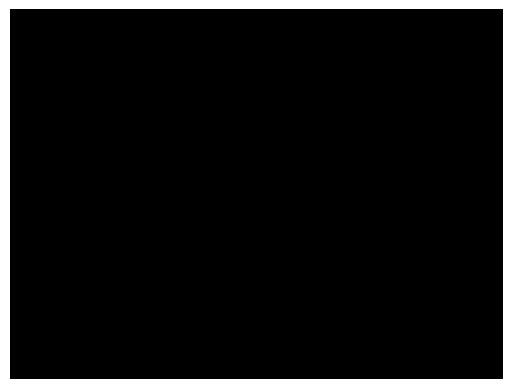

In [27]:
color_image_cpu_transposed = np.transpose(color_image_cpu, (1, 2, 0))

# Now we can display the image
plt.imshow(color_image_cpu_transposed)
plt.axis('off')  # Turns off the axis labels and ticks
plt.show()